<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/12_gan/06_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StyleGAN
GANで高解像な画像生成をするためには，人の目で見ても区別が付かない程，鮮明な画像を生成する必要があります．
つまり，鮮明でない画像は，Discriminatorで容易に本物か偽物かを区別できてしまうため，モード崩壊が起こります．<br>
この問題を回避する方法として，徐々に層を追加するプログレッシブな学習プロセスを使用しています．プログレッシブな学習は，Progressive Growing GAN (PG-GAN)で提案された方法です．

PG-GANと異なる点は，潜在変数を直接画像生成に使用するのではなく，Adaptive Instance Normalization (AdaIN)のパラメータに利用しています．
ここで，AdaINは，しばしばスタイル変換に利用されるNormalization方法です．
潜在変数をAdaINのパラメータに利用することでネットワークの浅い層と深い層で変化するスタイルに違いがあることを発見しました．

Generatorの入力層へ与える変数は，ランダムサンプリングしたベクトルではなく，学習初期に決定した任意のサイズの定数（4x4のmap）を入力として学習をしています．

## 必要モジュールのインポート

In [ ]:
import numpy as np
from PIL import Image
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

## ネットワーク構築のために必要なレイヤの定義
### Equalized Convolution，Equalized Linear
一般的にDeep Learningで識別，認識，分類をするときにネットワークを初期化する方法として，Heの初期化やXavierなど正規分布に基づく初期化が多用されています．
しかしながら，これらの初期化方法とAdamやRMSPropなどの最適化関数を組み合わせて学習をすることは，画像生成には適さないことがPG-GANの論文中で示されました．
StyleGANでも同様のレイヤが用いられており，以下のように動的に初期値を決定しています．
$$
w^{\prime}\leftarrow w\sqrt{\frac{2}{Ch * K}}
$$
ここで，$w$は正規分布からサンプリングした重みフィルタ，$Ch$はチャネル数，$K$はカーネルサイズ（全結合の場合は1）です．<br>

In [ ]:
class Equalized_LR:
    def __init__(self, name):
        self.name = name
        
    def compute_weight(self, module):
        weight = getattr(module, self.name+'_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()        
        return weight * sqrt(2 / fan_in)
    
    @staticmethod
    def apply(module, name):
        fn = Equalized_LR(name)

        weight = getattr(module, name)
        del module._parameters[name]
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        module.register_forward_pre_hook(fn)

        return fn
    
    def __call__(self, module, input):
        weight = self.compute_weight(module)
        setattr(module, self.name, weight)

def equal_lr(module, name='weight'):
    Equalized_LR.apply(module, name)
    return module

class EqualConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        self.conv = equal_lr(conv)

    def forward(self, input):
        return self.conv(input)

class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim, mapping_linear=False, 
                 gain=None, lrmul=None, bias=True, use_wscale=False):
        super().__init__()

        self.mapping_linear = mapping_linear
        linear = nn.Linear(in_dim, out_dim)
        linear.weight.data.normal_()
        linear.bias.data.zero_()

        if mapping_linear:
            he_std = gain * in_dim ** (-0.5)
            if use_wscale:
                init_std = 1.0 / lrmul
                self.w_mul = he_std * lrmul
            else:
                init_std = he_std / lrmul
                self.w_mul = lrmul
            self.weight = torch.nn.Parameter(torch.randn(out_dim, in_dim) * init_std)
            if bias:
                self.bias = torch.nn.Parameter(torch.zeros(out_dim))
                self.b_mul = lrmul
            else:
                self.bias = None
        else:
            self.linear = equal_lr(linear)

    def forward(self, input):
        if self.mapping_linear:
            bias = self.bias
            if bias is not None:
                bias = bias * self.b_mul
            return F.linear(input, self.weight * self.w_mul, bias)
        else:
            return self.linear(input)

### FusedUpsampling，FusedDownsampling
DC-GANをはじめとする多くのGANで問題視されている1つが，Generatorのアップサンプル時にartifactが載りやすいことです．
アップサンプリングでは，bilinear補間やdeconvolutionを用いて引き延ばすため，artifactが載りやすくなります．
この問題を解消するために，アップサンプル時のConvolutionで用いる重みフィルタにローパスフィルタ（ガウスフィルタ）を用いています．
これによって，鮮明な画像生成の手助けをしています．

この問題はダウンサンプル時にも同様のことが言えて，ダウンサンプル前にガウスフィルタを用います．

In [ ]:
class FusedUpsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()

        weight = torch.randn(in_channel, out_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)

        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)

        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (
            weight[:, :, 1:, 1:]
            + weight[:, :, :-1, 1:]
            + weight[:, :, 1:, :-1]
            + weight[:, :, :-1, :-1]
        ) / 4

        out = F.conv_transpose2d(input, weight, self.bias, stride=2, padding=self.pad)

        return out
    
class FusedDownsample(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding=0):
        super().__init__()

        weight = torch.randn(out_channel, in_channel, kernel_size, kernel_size)
        bias = torch.zeros(out_channel)

        fan_in = in_channel * kernel_size * kernel_size
        self.multiplier = sqrt(2 / fan_in)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(bias)

        self.pad = padding

    def forward(self, input):
        weight = F.pad(self.weight * self.multiplier, [1, 1, 1, 1])
        weight = (
            weight[:, :, 1:, 1:]
            + weight[:, :, :-1, 1:]
            + weight[:, :, 1:, :-1]
            + weight[:, :, :-1, :-1]
        ) / 4

        out = F.conv2d(input, weight, self.bias, stride=2, padding=self.pad)

        return out

### Pixel-wise normalization，Adaptive instance normalization
DC-GANでは，Batch Normalizationをネットワーク全体に使用することで高解像な画像生成をしていました．
Batch Normalizationは高精度な認識を得るためのネットワークに使用することは効果的ですが，単純にミニバッチで正規化をする処理は画像生成には適さないことが判明しました．
Batch Normalizationは，学習可能なパラメータを含むので，画像生成には不要かつモード崩壊を起こす1つの原因となるため，排除してPixel-wise normalizationと呼ばれる正規化が利用されています．
これはPG-GANでGeneratorの全層に用いられている，各画像で正規化をする方法です．
StyleGANでは，Mapping networkのみに利用されています．Pixel-wise normalizationは以下の式のとおりです．
$$
b_{x, y} = \frac{a_{x, y}}{\sqrt{\frac{1}{N}\sum_{j=0}^{N-1}(a_{x,y}^{j})^{2}+\epsilon}}
$$
ここで，$a_{x,y}, b_{x,y}$は，それぞれ正規化前の特徴マップと正規化後の特徴マップです．また，Nは特徴マップの総数で，$\epsilon=10^{-8}$です．

Adaptive instance normalizationは，pytorch内部で実装がされていますが，内部処理を少々変更する必要があるので以下に定義してあります．

In [ ]:
class PixelNorm(nn.Module):
    """
    Pixel-wise normalization
    """
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True) + 1e-8)

class AdaptiveInstanceNorm(nn.Module):
    """
    Adaptive instance normalization
    """
    def __init__(self, in_channel, style_dim):
        super().__init__()

        self.norm = nn.InstanceNorm2d(in_channel)
        self.style = EqualLinear(style_dim, in_channel * 2)

        self.style.linear.bias.data[:in_channel] = 1
        self.style.linear.bias.data[in_channel:] = 0

    def forward(self, input, style):
        style = self.style(style).unsqueeze(2).unsqueeze(3)
        gamma, beta = style.chunk(2, 1)

        out = self.norm(input)
        out = gamma * out + beta

        return out

### その他のレイヤ
* ConstantInput：Generatorに入力する任意のサイズの定数マップを作成するためのクラス．
* NoiseInjection：GeneratorのAdaINの前に与えるノイズを作成するために必要なクラス．
* Blur：ダウンサンプル，アップサンプル前後でローパスフィルタを施すために必要となるクラス．

In [ ]:
class ConstantInput(nn.Module):
    def __init__(self, channel, size=4):
        super().__init__()

        self.input = nn.Parameter(torch.randn(1, channel, size, size))

    def forward(self, batch):
        out = self.input.repeat(batch, 1, 1, 1)
        return out
    
class NoiseInjection(nn.Module):
    def __init__(self, channel):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channel, 1, 1))

    def forward(self, image, noise):
        return image + self.weight * noise
    
class Blur(nn.Module):
    def __init__(self, kernel=None, normalize=None, flip=None, stride=1):
        super(Blur, self).__init__()
        self.normalize = normalize
        self.flip = flip
        if kernel is None:
            kernel = [1, 2, 1]
        kernel = self.create_kernel(kernel)

        self.register_buffer('kernel', kernel)
        self.stride = stride
        
        
    def create_kernel(self, kernel):
        kernel = torch.tensor(kernel).float().view(1, len(kernel))
        kernel = kernel.t() * kernel
        kernel = kernel.unsqueeze(0).unsqueeze(0)
        
        if self.normalize:
            kernel /= kernel.sum()
        if self.flip:
            kernel = torch.flip(kernel, [2, 3])
        return kernel
    
    def forward(self, input):
        kernel = self.kernel.expand(input.size(1), -1, -1, -1)
        padding_size = int((self.kernel.size(2) - 1) / 2)
        return F.conv2d(input, kernel, stride=self.stride, 
                        padding=padding_size, groups=input.size(1))

## Generatorの定義
Generatorはいくつかのブロックを用いて構成します．
各ブロックは，2層の畳み込み処理を含んでいます．
この2層の内，１つ目の畳み込み処理の前に特徴マップをアップサンプルします．
全てのブロックの後に使用する活性化関数は，LeakyReLUです．
活性化関数の前にノイズを加算する処理であるNoise injectionを導入します．
活性化関数を通した後は，mapping networkで写像した空間$\mathcal{W}$からサンプリングした潜在変数と特徴マップを用いてAdaptive instance normalizationで正規化します．Generatorは，mapping networkを必要とするため，全結合層8層とLeakyReLUで非線形変換するネットワークを構築しています．

Generatorのネットワーク図を以下に示します．

<img src="https://www.dropbox.com/s/myeopyl0g9n4iks/StyleGAN_G.png?dl=1" width=40%>

また，StyleGANはプログレッシブな学習をするため，高解像度の画像を生成するために層を追加します．
しかしながら，数epoch学習した層と次の解像度を生成する初期値の畳み込み処理は，ギャップが大きいため徐々に新たに追加した層を反映するように線形変化する重み$\alpha$を使用します．<br>
以下に16×16から32×32への移り変わりを示す．

<img src="https://www.dropbox.com/s/c21cxt4bxdntlsn/G_transition.png?dl=1" width=40%>

In [ ]:
class GBlock(nn.Module):
    def __init__(self, in_features, out_features, kernel_size, stride, padding,
                 up=False, fused=False, n_style=512, initial=False):
        super(GBlock, self).__init__()
        if not initial:
            if up:
                if fused:
                    self.c1 = nn.Sequential(
                        FusedUpsample(in_features, out_features, kernel_size=kernel_size, padding=padding),
                        Blur([1, 2, 1], True, True, 1))
                else:
                    self.c1 = nn.Sequential(
                        nn.Upsample(scale_factor=2, mode='bilinear'),
                        Blur([1, 2, 1], True, True, 1),
                        EqualConv2d(in_features, out_features, kernel_size=kernel_size, stride=stride,
                                    padding=padding, bias=True)
                    )
            else:
                self.c1 = EqualConv2d(in_features, out_features, kernel_size=kernel_size, stride=stride,
                                          padding=padding, bias=True)
                
        self.initial = initial
        self.make_noise1 = NoiseInjection(out_features)
        self.adain1 = AdaptiveInstanceNorm(out_features, n_style)
        self.lrelu1 = nn.LeakyReLU(negative_slope=0.2)
        
        self.c2 = nn.Sequential(
            EqualConv2d(out_features, out_features, kernel_size=kernel_size, stride=stride,
                        padding=padding, bias=True))
        self.make_noise2 = NoiseInjection(out_features)
        self.adain2 = AdaptiveInstanceNorm(out_features, n_style)
        self.lrelu2 = nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, x, style_code, noise):
        out = x
        if not self.initial:
            out = self.c1(out)
        out = self.make_noise1(out, noise)
        out = self.lrelu1(out)
        out = self.adain1(out, style_code)

        out = self.c2(out)
        out = self.make_noise2(out, noise)
        out = self.lrelu2(out)
        out = self.adain2(out, style_code)
        return out

class Generator(nn.Module):
    def __init__(self, switch_ch=4, img_size=1024, n_ch=512, n_style=512, n_mapping_layers=8):
        super(Generator, self).__init__()
        n_block = int(np.log2(img_size))
        
        module_list = []
        conv_module_list = []
        fused = False
        in_ch = n_ch
        out_ch = n_ch
        for block_idx in range(1, n_block+1):
            if block_idx == 1:initial = True
            else:initial = False
            module_list.append(GBlock(in_ch, out_ch, kernel_size=3, stride=1, padding=1, up=True, fused=fused, initial=initial))
            conv_module_list.append(ConvBlock(out_ch, 3, kernel_size=1, stride=1, padding=0))
            if block_idx >= switch_ch:
                fused = True
                in_ch = out_ch
                out_ch = in_ch // 2
        
        mapping_network = [PixelNorm()]
        for i in range(n_mapping_layers):
            mapping_network.append(EqualLinear(n_style, n_style, mapping_linear=True, 
                                   gain=2 ** 0.5, lrmul=0.01, bias=True, use_wscale=True))
            mapping_network.append(nn.LeakyReLU(negative_slope=0.2))
        
        self.const = ConstantInput(n_ch)
        self.main_net = nn.ModuleList(module_list)
        self.to_rgb = nn.ModuleList(conv_module_list)
        self.mapping_network = nn.Sequential(*mapping_network)
        
    def forward(self, style, noise, depth=0, alpha=-1, true_size=1024):
        const = self.const(style.size(0))
        style_code = self.mapping_network(style)
        
        if depth > 0 and alpha < 1.0:
            h = const
            presize_noise = torch.randn(h.size(0), 1, h.size(2), h.size(3)).type_as(style)
            for i in range(depth - 1):
                size = true_size // (2 ** (depth - i))
                noise_roop = torch.randn(h.size(0), 1, size, size).type_as(style)
                h = self.main_net[i](h, style_code, noise_roop)
                presize_noise = torch.randn(h.size(0), 1, h.size(2)*2, h.size(3)*2).type_as(style)
            
            h1 = self.main_net[depth - 1](h, style_code, presize_noise)
            h2 = F.upsample(h1, scale_factor=2, mode='bilinear')
            h3 = self.to_rgb[depth - 1](h2)
            h4 = self.main_net[depth](h1, style_code, noise)
            h4 = self.to_rgb[depth](h4)
            
            h = h3 - alpha * (h3 - h4)
        else:
            h = const
            for i in range(depth):
                size = true_size // (2 ** (depth - i))
                noise_roop = torch.randn(h.size(0), 1, size, size).type_as(style)
                h = self.main_net[i](h, style_code, noise_roop)
                
            h = self.main_net[depth](h, style_code, noise)
            h = self.to_rgb[depth](h)
        
        return h

## Discriminatorの定義
DiscriminatorもGeneratorと同様でいくつかのブロックが積み重なったネットワークです．DiscriminatorへはBatchNormalizationなどの正規化を一切使用しません．
DiscriminatorもGeneratorと同様で，スムーズに解像度の移り変わりができるように線形増加する$\alpha$によって徐々に次の改造へ移り変わるネットワーク構造を使用します．

<img src="https://www.dropbox.com/s/zpfdnq4gcilochs/StyleGAN_D_transition.png?dl=1" width=40%>

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_features, out_features, kernel_size, stride,
                 padding, down=False, fused=False, d_last=False):
        super(ConvBlock, self).__init__()
        
        conv_layer1 = [
            EqualConv2d(in_features, out_features, kernel_size=kernel_size, stride=stride,
                        padding=padding, bias=True),
            nn.LeakyReLU(negative_slope=0.2)
        ]
        
        if d_last:
            kernel_size = 4
            stride = 1
            padding = 0
            
        if down:
            if fused:
                conv_layer2 = [
                    Blur([1, 2, 1], True, True, 1),
                    FusedDownsample(out_features, out_features, kernel_size=kernel_size, padding=padding),
                    nn.LeakyReLU(negative_slope=0.2)
                ]
            else:
                conv_layer2 = [
                    Blur([1, 2, 1], True, True, 1),
                    EqualConv2d(out_features, out_features, kernel_size=kernel_size, stride=stride,
                        padding=padding, bias=True),
                    nn.AvgPool2d(2, 2),
                    nn.LeakyReLU(negative_slope=0.2)
                ]
        else:
            conv_layer2 = [
                EqualConv2d(out_features, out_features, kernel_size=kernel_size, stride=stride,
                            padding=padding, bias=True),
                nn.LeakyReLU(negative_slope=0.2)
            ]
        
        self.c1 = nn.Sequential(*conv_layer1)
        self.c2 = nn.Sequential(*conv_layer2)
    
    def forward(self, x):
        h = self.c1(x)
        out = self.c2(h)
        return out

class Discriminator(nn.Module):
    def __init__(self, switch_ch=4, img_size=1024, n_ch=16):
        super(Discriminator, self).__init__()
        n_block = int(np.log2(img_size))
        self.total_depth = n_block - 1
        
        module_list = []
        conv_module_list = []
        down = True
        fused = False
        d_last = False
        in_ch = n_ch
        out_ch = n_ch
        for block_idx in range(1, n_block+1):
            if block_idx == n_block:
                down = False
                d_last = True
            conv_module_list.append(nn.Sequential(EqualConv2d(3, in_ch, kernel_size=1, stride=1, padding=0),
                                    nn.LeakyReLU(negative_slope=0.2)))
            module_list.append(ConvBlock(in_ch, out_ch, kernel_size=3, stride=1, padding=1, down=down, fused=fused, d_last=d_last))
            if block_idx <= switch_ch + 1:
                fused = True
                in_ch = out_ch
                out_ch = in_ch * 2
            else:
                in_ch = out_ch
            
        self.main_net = nn.Sequential(*module_list)
        self.from_rgb = nn.Sequential(*conv_module_list)
        self.linear = EqualLinear(out_ch, 1)
        
    def forward(self, x, depth=0, alpha=0):
        if depth > 0 and alpha < 1.0:
            h1 = self.from_rgb[self.total_depth - depth](x)
            h1 = self.main_net[self.total_depth - depth](h1)
            x2 = F.avg_pool2d(x, 2, 2)
            h2 = F.leaky_relu(self.from_rgb[self.total_depth - depth+1](x2))
            h = h2 - alpha * (h2 - h1)
            
        else:
            h = self.from_rgb[self.total_depth - depth](x)
            h = self.main_net[self.total_depth - depth](h)
            
        for i in range(depth):
            h = self.main_net[self.total_depth - depth+1+i](h)
            
        out = self.linear(h.view(h.size(0), -1))
        return out

In [ ]:
img_size = 1024
n_ch = 512
n_style = 512
n_mapping = 8
model_path = './result/gen_ema_512x512'
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
G = Generator(switch_ch=4, img_size=img_size, n_ch=n_ch, n_style=n_style, n_mapping_layers=n_mapping).to(device)
G.load_state_dict(torch.load(model_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## StyleGANの学習コード
StyleGANは，非常に多くの時間と計算リソースを必要とする手法です．
そのため，Colabratory上では到底学習が終わりません．
余力よ計算リソースがある人は，以下のコードを利用して好きなデータセットで学習をしてみてください．


In [ ]:
!wget -q https://www.dropbox.com/s/v8vdmzk4l50qtw7/params.yml?dl=1 -O params.yml

In [ ]:
def update_EMA(src, tgt, strength=0.999):
    with torch.no_grad():
        paramnames = dict(src.module.named_parameters())
        for k, v in tgt.named_parameters():
            param = paramnames[k].detach().cpu()
            v.copy_(strength * v + (1 - strength) * param)

In [ ]:
def gradient_penalty(real_img, fake_img, alpha, d):           
    eps = torch.rand(real_img.size(0), 1, 1, 1).cuda().expand_as(real_img)
    interpolated = torch.autograd.Variable(eps * real_img.data + (1 - eps) * fake_img.data, 
                                           requires_grad=True)
    out = D(interpolated, d, alpha=alpha)

    grad = torch.autograd.grad(outputs=out,
                               inputs=interpolated,
                               grad_outputs=torch.ones(out.size()).to(device),
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    grad = grad.view(grad.size(0), -1)
    grad_l2norm = torch.sqrt(torch.sum(grad ** 2, dim=1))
    d_loss_gp = torch.mean((grad_l2norm - 1) ** 2)
    
    return d_loss_gp

In [ ]:
yaml_path = "params.yml"
with open(yaml_path, 'r+') as f:
    training_params = yaml.load(f)

depth = 9
alpha = 0
n_style = 512
lambda_r1 = 10
lambda_drift = 1e-3
lambda_gp = 10
loss_func = 'hinge'

for d in range(depth):
    print('='*50, 'Now network depth is %d' % d, '='*50)
    size = 4 * 2 ** d
    alpha = alpha
    iteration = 0
    delta = deltas['%dx%d' % (size, size)]
    epoch = epochs['%dx%d' % (size, size)]
    batch = batch_size['%dx%d' % (size, size)]
    transform_train = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()])
    training_data = DatasetMaker(size, conf.h5py_path, conf.data_path, conf.txt_path, transform=transform_train)
    training_dataset = DataLoader(dataset=training_data, batch_size=batch,
                                  drop_last=True, shuffle=True, num_workers=conf.workers)
    
    print('Delta: %f' % delta)
    print('Epoch: %d' % epoch)
    print('Mini batch size: %d' % batch_size['%dx%d' % (size, size)])
    print('Learning rate: %f' % lr['%dx%d' % (size, size)])
    print('='*50, 'Currently, image size is %d x %d' % (size, size), '='*50)
    
    for g_params in G_opt.param_groups:
        g_params['lr'] == lr['%dx%d' % (size, size)]
    for d_params in D_opt.param_groups:
        d_params['lr'] == lr['%dx%d' % (size, size)]
    G.train()
    D.train()
    #for epoch in range(1, epochs['%dx%d' % (size, size)]+1):
    for epoch in range(1, epoch+1):
        Tensor = torch.cuda.FloatTensor
        for idx, img in enumerate(training_dataset):
            flag_real = Tensor(img.size(0)).fill_(1.0)
            flag_fake = Tensor(img.size(0)).fill_(0.0)
            real_img = img.to(device)
            noise = torch.randn(real_img.size(0), 1, size, size).to(device)
            style_noise = torch.randn(real_img.size(0), n_style).to(device)
        
            # ====================== Update Discriminator ======================
            D.zero_grad()
            dis_real_out = D(real_img, d, alpha=alpha)
            fake_img = G(style_noise, noise, d, alpha=alpha, true_size=size)
            dis_fake_out = D(fake_img, d, alpha=alpha)
            
            if loss_func == 'wgan-gp':
                dis_real = - torch.mean(dis_real_out)
                dis_fake = torch.mean(dis_fake_out)
            elif loss_func == 'hinge':
                dis_real = nn.ReLU()(1.0 - dis_real_out).mean()
                dis_fake = nn.ReLU()(1.0 + dis_fake_out).mean()
            elif loss_func == 'relativistic_hinge':
                r_diff = dis_fake_out - torch.mean(dis_real_out)
                f_diff = dis_real_out - torch.mean(dis_fake_out)
                dis_real = nn.ReLU()(1.0 + r_diff).mean()
                dis_fake = nn.ReLU()(1.0 - f_diff).mean()
            elif loss_func == 'R1':
                dis_real = criterion(dis_real_out.view(-1), flag_real)
                dis_fake = criterion(dis_fake_out.view(-1), flag_fake)
            
            dis_loss = dis_real + dis_fake
            
            if loss_func == 'R1':
                real_img_detach = torch.autograd.Variable(real_img, requires_grad=True)
                dis_real_out = D(real_img_detach, d, alpha=alpha).view(real_img.size(0), -1)
                dis_grad = torch.autograd.grad(outputs=dis_real_out,
                               inputs=real_img,
                               grad_outputs=torch.ones(dis_real_out.size()).to(device),
                               retain_graph=True,
                               create_graph=True)[0].view(real_img.size(0), -1)
                r1_penalty = torch.sum(torch.mul(dis_grad, dis_grad))
                r1_loss = lambda_r1 / 2 + r1_penalty
                dis_loss += r1_loss
            elif loss_func == 'wgan-gp':
                loss_gp = gradient_penalty(real_img, fake_img, alpha, d)
                d_drift = lambda_drift * torch.mean(dis_real ** 2)
                dis_loss = dis_loss + lambda_gp * loss_gp + d_drift
            
            dis_loss.backward()
            D_opt.step()
        
            # ====================== Update Generator ======================
            G.zero_grad()
            style_noise = torch.randn(real_img.size(0), conf.n_style)
            fake_img = G(style_noise, noise, d, alpha=alpha, true_size=size)
            gen_out = D(fake_img, d, alpha=alpha)
            if loss_func == 'wgan-gp' or 'hinge':
                gen_loss = - gen_out.mean()
            elif loss_func == 'relativistic_hinge':
                r_diff = gen_out - torch.mean(dis_real_out)
                f_diff = dis_real_out - torch.mean(gen_out)
                gen_real_loss = nn.ReLU()(1.0 - r_diff).mean()
                gen_fake_loss = nn.ReLU()(1.0 + f_diff).mean()
                gen_loss = gen_real_loss + gen_fake_loss
            elif loss_func == 'R1':
                gen_loss = criterion(gen_out.view(-1), flag_real)
                
            gen_loss.backward()
            G_opt.step()
            update_EMA(G, G_ema, strength=0.999)
            
            alpha = min(1, alpha + delta)
        
            iteration += 1
            if idx %  100 == 0:
                print('Training epoch: {} [{}/{} ({:.0f}%)] | D loss : {:.6f} | G loss: {:.6f} | Alpha: {:.6f}|'\
                      .format(epoch, idx * len(img), len(training_dataset.dataset),
                      100. * idx / len(training_dataset), dis_loss.item(), gen_loss.item(), alpha))
                
                tb.add_scalars('prediction loss depth%d' % d,
                               {'D': dis_loss.item(),
                                'G': gen_loss.item()},
                                iteration)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
d = 7
alpha = 1
size = 4 * 2 ** d
style_noise = torch.randn(20, n_style).to(device)
noise = torch.randn(20, 1, size, size).to(device)
fake_img = G(style_noise, noise, d, alpha=alpha, true_size=size)

torch.Size([3, 512, 512])


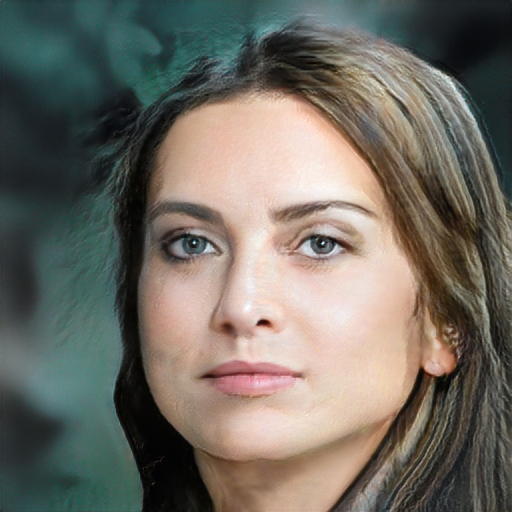

In [ ]:
from PIL import Image
img = fake_img[np.random.randint(len(fake_img))]
print(img.shape)
Image.fromarray((img * 256.).clamp(min=0, max=255).data.cpu().permute(1,2,0).numpy().astype(np.uint8))

In [ ]:
#import torch
#from models import Generator
#import numpy as np
#from PIL import Image

d = 7
size = 4 * 2 ** d
#G = Generator()
#path = 'result/gen_ema'
#G.load_state_dict(torch.load(path))
a = torch.randn(10, 1, size, size)
b = torch.randn(10, 512)
gen = G(b, a, d, alpha=1, true_size=size)
#print(gen[1].data.cpu())
img_gen = (gen[1] * 256.).clamp(min=0, max=255).data.cpu().numpy().transpose(1,2,0).astype(np.uint8)
print(img_gen.shape)
Image.fromarray(img_gen)

AttributeError: 'int' object has no attribute 'shape'

## 課題
* StyleCodeを動かすと，どのようになるでしょうか？また，写像した空間からサンプリングした潜在変数を各解像度で補間したときにどのような変化が現れるか確認してください．